In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 



2023-10-31 06:21:12.946354: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 06:21:13.355915: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 06:21:13.355940: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 06:21:13.358449: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-31 06:21:13.589514: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 06:21:13.591465: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

  Emotions                                               Path
0      sad  dataset/Ravdess/audio_speech_actors_01-24/Acto...
1    angry  dataset/Ravdess/audio_speech_actors_01-24/Acto...
2     fear  dataset/Ravdess/audio_speech_actors_01-24/Acto...
3    happy  dataset/Ravdess/audio_speech_actors_01-24/Acto...
4    angry  dataset/Ravdess/audio_speech_actors_01-24/Acto...


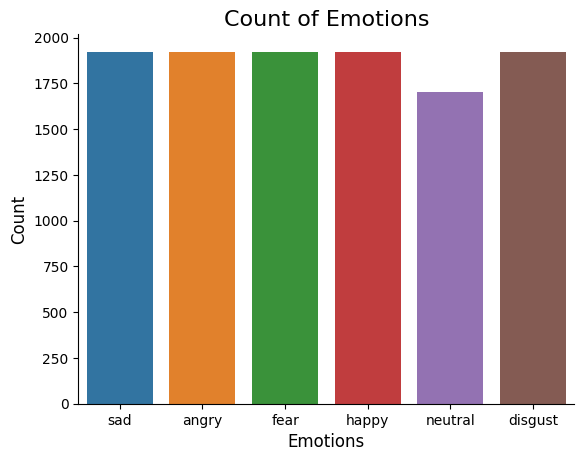

In [2]:
#make true in order to regenerate emotions_png
REGEN_SHIT = False
if not REGEN_SHIT:
    data_path = pd.read_csv('data_path.csv')
    print(data_path.head())
if REGEN_SHIT:
    Ravdess = "dataset/Ravdess/audio_speech_actors_01-24/"
    Crema = "dataset/Crema/"
    Tess = "dataset/Tess/"
    Savee = "dataset/Savee/"
    ravdess_directory_list = os.listdir(Ravdess)

    file_emotion = []
    file_path = []
    for dir in ravdess_directory_list:
        # as their are 20 different actors in our previous directory we need to extract files for each actor.
        actor = os.listdir(Ravdess + dir)
        for file in actor:
            part = file.split('.')[0]
            part = part.split('-')
            # third part in each file represents the emotion associated to that file.
            if int(part[2]) == 2 or int(part[2]) == 8: continue
            # REMOVE suprise AND CALM
            file_emotion.append(int(part[2]))
            file_path.append(Ravdess + dir + '/' + file)
            
    # dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

    # changing integers to actual emotions.
    Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
    Ravdess_df.head()

    # Crema Processing
    crema_directory_list = os.listdir(Crema)

    file_emotion = []
    file_path = []

    for file in crema_directory_list:
        # storing file paths
        file_path.append(Crema + file)
        # storing file emotions
        part=file.split('_')
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')
            
    # dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Crema_df = pd.concat([emotion_df, path_df], axis=1)
    Crema_df.head()

    #tess processing
    tess_directory_list = os.listdir(Tess)

    file_emotion = []
    file_path = []

    for dir in tess_directory_list:
        directories = os.listdir(Tess + dir)
        for file in directories:
            part = file.split('.')[0]
            part = part.split('_')[2]
            if part=='ps':
                continue
            else:
                file_emotion.append(part)
            file_path.append(Tess + dir + '/' + file)
            
    # dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Tess_df = pd.concat([emotion_df, path_df], axis=1)
    Tess_df.head()

    #savee processing
    savee_directory_list = os.listdir(Savee)

    file_emotion = []
    file_path = []

    for file in savee_directory_list:
        file_path.append(Savee + file)
        part = file.split('_')[1]
        ele = part[:-6]
        if ele=='a':
            file_emotion.append('angry')
        elif ele=='d':
            file_emotion.append('disgust')
        elif ele=='f':
            file_emotion.append('fear')
        elif ele=='h':
            file_emotion.append('happy')
        elif ele=='n':
            file_emotion.append('neutral')
        elif ele=='sa':
            file_emotion.append('sad')
        #else:
            #file_emotion.append('surprise')
            
    # dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Savee_df = pd.concat([emotion_df, path_df], axis=1)
    Savee_df.head()

    #to csv
    data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
    data_path.to_csv("data_path.csv",index=False)
    data_path.head()

plt.title('Count of Emotions', size=16)
sns.countplot(x=data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

    


In [3]:
    

    def create_waveplot(data, sr, e):
        pd.Series(data).plot(figsize=(10, 3),
                      lw=1,
                      title='Waveplot for audio with {} emotion'.format(e),
                      color="blue")
        plt.show()

    def create_spectrogram(data, sr, e):
        # stft function converts the data into short term fourier transform
        X = librosa.stft(data)
        Xdb = librosa.amplitude_to_db(abs(X))
        
        plt.figure(figsize=(4, 2))
        # plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
        librosa.display.specshow(Xdb, sr=sr)   



In [4]:
    REGENERATE_IMAGES = False
    #generate the normal images
    if(REGENERATE_IMAGES):
        total = 0
        from IPython.display import clear_output
        emotions=['happy', 'sad', 'angry', 'disgust', 'neutral', 'fear']
        headpath = os.path.join(os.getcwd(), "emotions_png")
        if not os.path.isdir(headpath):
            os.mkdir(headpath)
        for em in emotions:
            p2 = os.path.join(headpath, em) 
            if not os.path.isdir(p2):
                os.mkdir(p2)
        
            ct = 0
            processlist = np.array(data_path.Path[data_path.Emotions==em])
            for path in processlist:
                data, sampling_rate = librosa.load(path)
                if os.path.isfile(f'emotions_png/{em}/image{ct}.png'):
                    #this might be a point of issue if the array is random every time but hopefully that won't be an issue... right?
                    clear_output(wait = True)
                    ct += 1
                    total += 1
                    print(f"Percent Done: {(total/11378*100):.2f}%")
                    continue
                    #there is 100% a better way to do this but whatev
                
                create_spectrogram(data, sampling_rate, em)
                plt.savefig(f'emotions_png/{em}/image{ct}.png', bbox_inches='tight', pad_inches=0) 
                plt.clf()
                plt.cla()
                plt.close()
                #prevent memory leak
        
                ct += 1
                total += 1
                clear_output(wait = True)
                print(f"Percent Done: {(total/11378*100):.2f}%")

In [5]:
    def noise(data):
        noise_amp = 0.01*np.random.uniform()*np.amax(data)
        data = data + noise_amp*np.random.normal(size=data.shape[0])
        return data
    
    def stretch(data, rate=1.5):
        return librosa.effects.time_stretch(y=data, rate=rate)
    
    def shift(data):
        shift_range = int(np.random.uniform(low=-8, high = 8)*1000)
        return np.roll(data, shift_range)
    """
    data, sampling_rate = librosa.load(np.array(data_path.Path[data_path.Emotions=="fear"])[0])
    create_spectrogram((data), sampling_rate, "test")
    plt.show()
    create_spectrogram(noise(data), sampling_rate, "test")
    plt.show()
    create_spectrogram(stretch(data), sampling_rate, "test")
    plt.show()
    create_spectrogram(shift(data), sampling_rate, "test")
    plt.show()

    """
    "bruh"


'bruh'

In [6]:
    
    REGENERATE_ALTIMAGES = False
    import random

    #generate the changed images
    if(REGENERATE_ALTIMAGES):
        total = 0
        from IPython.display import clear_output
        emotions=['happy', 'sad', 'angry', 'disgust', 'neutral', 'fear']
        headpath = os.path.join(os.getcwd(), "emotions_png")
        if not os.path.isdir(headpath):
            os.mkdir(headpath)
        for em in emotions:
            p2 = os.path.join(headpath, em) 
            if not os.path.isdir(p2):
                os.mkdir(p2)
        
            ct = 0
            processlist = np.array(data_path.Path[data_path.Emotions==em])
            for path in processlist:
                data, sampling_rate = librosa.load(path)
                if os.path.isfile(f'emotions_png/{em}/imageAlt{ct}.png'):
                    #this might be a point of issue if the array is random every time but hopefully that won't be an issue... right?
                    clear_output(wait = True)
                    ct += 1
                    total += 1
                    print(f"Percent Done: {(total/11378*100):.2f}%")
                    continue
                    #there is 100% a better way to do this but whatev
                rando = random.randint(1,3)
                if rando == 1:
                    data = noise(data)
                elif rando == 2:
                    data = stretch(data)
                elif rando == 3:
                    data = shift(data)
                create_spectrogram(data, sampling_rate, em)
                plt.savefig(f'emotions_png/{em}/imageAlt{ct}.png', bbox_inches='tight', pad_inches=0) 
                plt.clf()
                plt.cla()
                plt.close()
                #prevent memory leak
        
                ct += 1
                total += 1
                clear_output(wait = True)
                print(f"Percent Done: {(total/11378*100):.2f}%")

In [39]:
#get the files in here and ball

import pathlib

img_width, img_height = 310, 154
batch_size = 16

data_dir = pathlib.Path("emotions_png").with_suffix('')
#split the data between training and validation
train_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


import tensorflow as tf
print(train_ds.class_names)

AUTOTUNE = tf.data.AUTOTUNE
# make things work more efficiently??
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 22636 files belonging to 6 classes.
Using 18109 files for training.
Found 22636 files belonging to 6 classes.
Using 4527 files for validation.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']


In [40]:
num_classes = 6


model = tf.keras.Sequential([
  #cnn
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  
  #dense
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

prevent_overfit = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min'
)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100,
  callbacks=[prevent_overfit]
)
print(f"Done in {len(history.history['loss'])} epochs with a final val_accuracy of {history.history['val_accuracy'][-1]}")

Epoch 1/100
 171/1132 [===>..........................] - ETA: 1:48 - loss: 1.7122 - accuracy: 0.2935

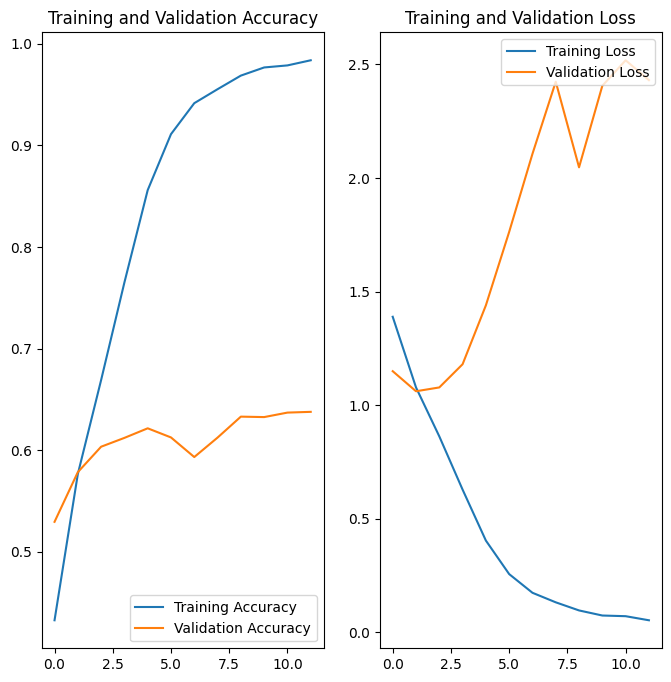

[0.43272751569747925,
 0.5766124129295349,
 0.669127881526947,
 0.765177309513092,
 0.8560519814491272,
 0.9111447930335999,
 0.9416256546974182,
 0.9553830623626709,
 0.9687618613243103,
 0.9767764806747437,
 0.9787958860397339,
 0.983844518661499]

In [35]:
acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
history.history['accuracy']


In [37]:
# predicting on test data.
y_prediction = model.predict(val_ds)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)


283/283 [==============================] - 5s 19ms/step


NameError: name 'y_test' is not defined

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

# vim: set filetype=python: